In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from scipy.signal import savgol_filter
from joblib import load
from tqdm import tqdm
import helper_scripts
import unsupervised_scripts

### TRAIN MODEL

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(input('Enter HSI step size: ').strip()) 
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')
shift = 15

## Training Directory (different for everyone)
path_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
data_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
sample_dir = data_dir + 'training_data/'+str(num_samp)+'/'

artificial_dataset = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df, shift)
[image_vec, _, _,_] = artificial_dataset.save_srs_params(sample_dir)
[mol_norm, mol_names] = artificial_dataset.molecule_dataset(molecule_df)
data_norm = artificial_dataset.DAE_dataset(mol_norm)

X_data = np.load('denoising_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_standard = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_standard = preprocessing.spectral_standardization(image_vec)
image_max = np.max(np.percentile(image_standard,99,axis=0))
image_norm = helper_scripts.normalize_manual(image_standard, max_val=image_max, min_val=np.median(image_standard[:,:ch_start]))
image_norm = image_norm.T-np.median(image_norm[:,:ch_start],axis=1)
image_norm = image_norm.T
X_norm = helper_scripts.normalize(X_standard, max=np.mean([np.max(image_norm), np.percentile(image_norm, 99)]))
X_norm = X_norm.T-np.median(X_norm[:,:ch_start],axis=1)
X_norm = X_norm.T

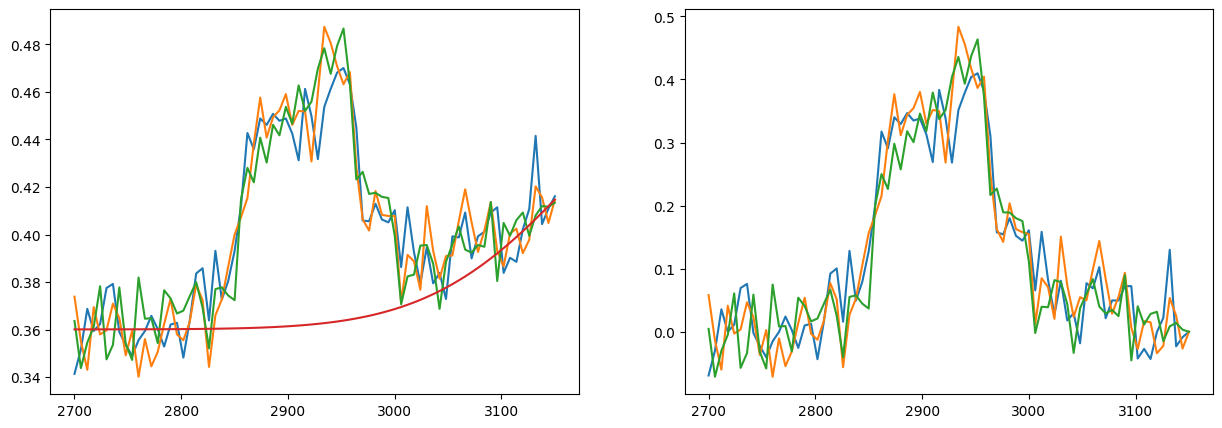

In [ ]:
background = artificial_dataset.background
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
rand_idx = np.random.randint(image_norm.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(wavenumbers, image_vec[rand_idx:rand_idx+3].T)
ax[0].plot(wavenumbers,helper_scripts.normalize(background, np.mean(image_vec[rand_idx:rand_idx+3,-1:-2:-1]), np.mean(image_vec[rand_idx:rand_idx+3,0:ch_start])))
ax[1].plot(wavenumbers,image_norm[rand_idx:rand_idx+3].T)

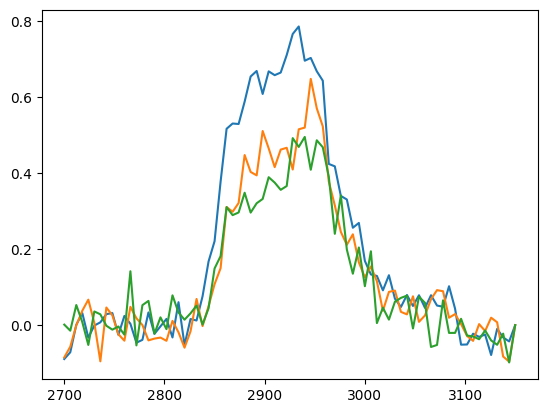

In [ ]:
indeces = [np.random.randint(0,image_norm.shape[0]-1), np.random.randint(0,image_norm.shape[0]-1), np.random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers,image_norm[indeces].T)


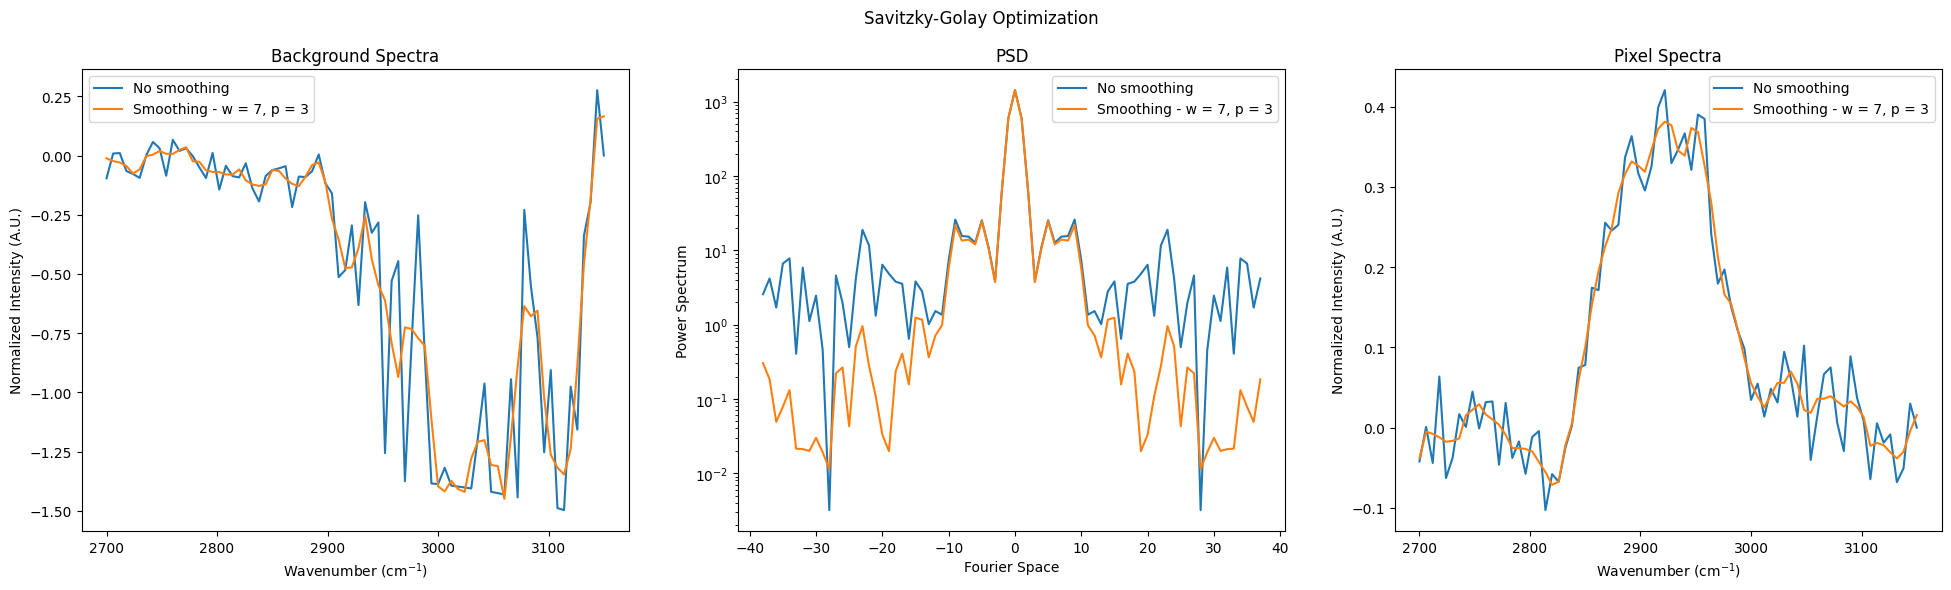

In [ ]:
w = int(input('Enter window size for Savitzky-Golay smoothing (Default="auto"): ').strip() or str(int(np.floor(num_samp/10))))
p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default="auto"): ').strip() or str(int(w/2)))
preprocessing.sav_gol_optimization(image_norm, w, p)
x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')

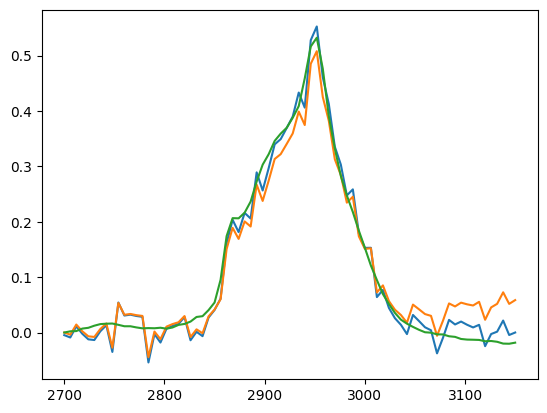

In [ ]:
idx = 1
mult = np.random.randint(0, 100)
a = X_norm[(26*(mult-1))+idx].T
b = helper_scripts.normalize(np.flip(X[(26*(mult-1))+idx].T),np.max(a))
c = helper_scripts.normalize(mol_norm[idx].T,np.max(a))
plt.plot(wavenumbers, a)
plt.plot(wavenumbers, b-b[0])
plt.plot(wavenumbers, c-c[0])

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm

Data = np.moveaxis(np.flip(X_data,axis=2), 0, 1)
Label = np.tile(data_norm, (X_data.shape[0], 1, 1))
Label = np.moveaxis(Label, 0, 1)
X = np.reshape(Data, (Data.shape[0]*Data.shape[1], Data.shape[2]))
X = helper_scripts.normalize_idx(X.T).T
Y = np.reshape(Label, (Label.shape[0]*Label.shape[1], Label.shape[2]))

dataset = TensorDataset(torch.from_numpy(X).unsqueeze(1), torch.from_numpy(Y))
train_data, val_data = random_split(dataset, [0.7, 0.3])
dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True, pin_memory=True)

class DenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.ReLU(),         
        )

        self.decoder = nn.Sequential(         
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(4, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded_vec = self.decoder(encoded)
        decoded = decoded_vec.squeeze(1)
        return decoded


# Move model and variables to CUDA
model = DenoisingAE()
model = nn.DataParallel(model)
device = torch.device("cuda:0")# if torch.cuda.is_available() else "cpu")
model.to(device)

# Training
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
criterion = nn.MSELoss()
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for data in tqdm(dataloader):
        inputs, targets = data
        # inputs = inputs.unsqueeze(1)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.double(), targets.double())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step(epoch_loss / len(dataloader))
    print(f'\nEpoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(dataloader):.6f}')
torch.save(model.module.state_dict(), 'denoising_autoencoder.pth')

  0%|          | 0/35657 [00:00<?, ?it/s]c:\Users\jvill\anaconda3\envs\Shi\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████▉| 35621/35657 [01:57<00:00, 334.96it/s]c:\Users\jvill\anaconda3\envs\Shi\Lib\site-packages\torch\nn\modules\conv.py:797: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv_transpose1d(
100%|██████████| 35657/35657 [01:57<00:00, 302.94it/s]



Epoch [1/10], Loss: 0.007257


100%|██████████| 35657/35657 [01:48<00:00, 329.16it/s]



Epoch [2/10], Loss: 0.002841


  3%|▎         | 895/35657 [00:02<01:56, 299.39it/s]


KeyboardInterrupt: 

In [ ]:
# Move model and variables to CUDA
model = DenoisingAE()
model = nn.DataParallel(model)
model.to(device)

# Training
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
criterion = nn.MSELoss()
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for data in tqdm(dataloader):
        inputs, targets = data
        # inputs = inputs.unsqueeze(1)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.double(), targets.double())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step(epoch_loss / len(dataloader))
    print(f'\nEpoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(dataloader):.6f}')
torch.save(model.module.state_dict(), 'denoising_autoencoder.pth')

  0%|          | 0/35657 [00:00<?, ?it/s]c:\Users\jvill\anaconda3\envs\Shi\Lib\site-packages\torch\nn\modules\conv.py:303: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
c:\Users\jvill\anaconda3\envs\Shi\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 35657/35657 [01:55<00:00, 308.01it/s]



Epoch [1/10], Loss: 0.005170


100%|██████████| 35657/35657 [01:51<00:00, 319.28it/s]



Epoch [2/10], Loss: 0.002965


100%|██████████| 35657/35657 [01:52<00:00, 316.54it/s]



Epoch [3/10], Loss: 0.002254


100%|██████████| 35657/35657 [01:53<00:00, 314.96it/s]



Epoch [4/10], Loss: 0.002103


100%|██████████| 35657/35657 [01:55<00:00, 309.89it/s]



Epoch [5/10], Loss: 0.001845


100%|██████████| 35657/35657 [01:51<00:00, 318.43it/s]



Epoch [6/10], Loss: 0.001773


100%|██████████| 35657/35657 [01:52<00:00, 316.68it/s]



Epoch [7/10], Loss: 0.001663


100%|██████████| 35657/35657 [01:51<00:00, 319.86it/s]



Epoch [8/10], Loss: 0.001679


100%|██████████| 35657/35657 [01:51<00:00, 320.67it/s]



Epoch [9/10], Loss: 0.001610


100%|██████████| 35657/35657 [01:51<00:00, 320.63it/s]



Epoch [10/10], Loss: 0.001721


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAE()
model.load_state_dict(torch.load('denoising_autoencoder.pth'))
model.to(device)
model.eval()

# Assuming test_inputs is a tensor of shape (N, 1, D)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)
denoised_outputs = []#
with torch.no_grad():  # No need to calculate gradients for evaluation
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        denoised_outputs.append(outputs.cpu())

# Concatenate the denoised outputs
denoised_outputs = torch.cat(denoised_outputs, dim=0)
denoised_data = np.array(denoised_outputs)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAE()
model.load_state_dict(torch.load('denoising_autoencoder.pth'))
model.to(device)
model.eval()

# Assuming test_inputs is a tensor of shape (N, 1, D)
test_loader = DataLoader(np.float32(helper_scripts.normalize_idx(image_vec.T).T), batch_size=1, shuffle=False)
denoised_outputs = []#
with torch.no_grad():  # No need to calculate gradients for evaluation
    for data in tqdm(test_loader):
        inputs = data.to(device)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        denoised_outputs.append(outputs.cpu())

# Concatenate the denoised outputs
denoised_outputs = torch.cat(denoised_outputs, dim=0)
denoised_data = np.array(denoised_outputs)

100%|██████████| 2036217/2036217 [25:56<00:00, 1307.99it/s]


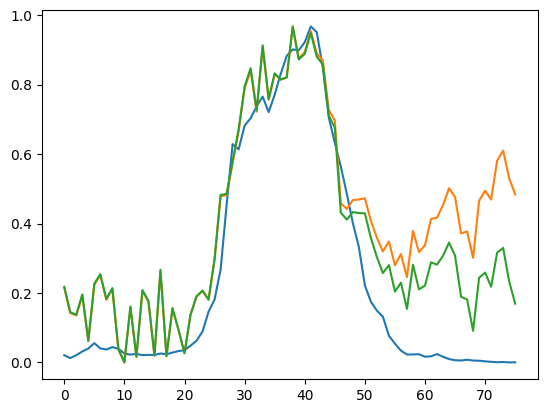

In [ ]:
index = np.random.randint(0, int(image_vec.shape[1]))
d_image = denoised_data[index]
plt.plot(d_image)
plt.plot(helper_scripts.normalize(image_vec[index], np.max(d_image)))
plt.plot(helper_scripts.normalize(image_norm[index], np.max(d_image)))